In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import tensorflow as tf
#import math


In [2]:
Mnist_data = np.loadtxt("fashionmnist/fashion-mnist_train.csv",delimiter=',', dtype=np.float32)
Mnist_test = np.loadtxt("fashionmnist/fashion-mnist_test.csv",delimiter=',', dtype=np.float32)

In [3]:
Train_x = Mnist_data[:, 1:]
Train_y = Mnist_data[:, 0]

Test_x = Mnist_test[:, 1:]
Test_y = Mnist_test[:, 0]

Train_y_one_hot = tf.one_hot(Train_y, depth=10, name="One_hot_op")
Test_y_one_hot = tf.one_hot(Test_y, depth=10, name='testonehot_op')


In [8]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.keep_prob = tf.placeholder(tf.float32)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            # img 28x28x1 (black/white)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # L1 ImgIn shape=(?, 28, 28, 1)
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            #    Conv     -> (?, 28, 28, 32)
            #    Pool     -> (?, 14, 14, 32)
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
            Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
            '''

            # L2 ImgIn shape=(?, 14, 14, 32)
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            #    Conv      ->(?, 14, 14, 64)
            #    Pool      ->(?, 7, 7, 64)
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
            Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
            '''

            # L3 ImgIn shape=(?, 7, 7, 64)
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            #    Conv      ->(?, 7, 7, 128)
            #    Pool      ->(?, 4, 4, 128)
            #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                                1, 2, 2, 1], padding='SAME')
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)

            L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
            '''
            Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
            '''

            # L4 FC 4x4x128 inputs -> 625 outputs
            W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            '''
            Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
            Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
            '''

            # L5 Final FC 625 inputs -> 10 outputs
            W5 = tf.get_variable("W5", shape=[625, 10],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            self.logits = tf.matmul(L4, W5) + b5
            '''
            Tensor("add_1:0", shape=(?, 10), dtype=float32)
            '''

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, keep_prop=1.0):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})

    def get_accuracy(self, x_test, y_test, keep_prop=1.0):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})

    def train(self, x_data, y_data, keep_prop=0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.keep_prob: keep_prop})

    
'''
dropout_rate = tf.placeholder("float")

with tf.name_scope('Input'):
    X = tf.placeholder(tf.float32, [None, 784])
    Y = tf.placeholder(tf.float32, [None, 10])

with tf.name_scope('H_Layer1'):
    W1 = tf.Variable(tf.random_normal([784, 512]))
    B1 = tf.Variable(tf.random_normal([512]))
    _L1 = tf.nn.relu(tf.add(tf.matmul(X,W1),B1))
   # L1 = tf.nn.dropout(_L1, dropout_rate)

with tf.name_scope('H_Layer2'):
    W2 = tf.Variable(tf.random_normal([512,256]))
    B2 = tf.Variable(tf.random_normal([256]))
    _L2 = tf.nn.relu(tf.add(tf.matmul(_L1, W2),B2))
    #L2 = tf.nn.dropout(_L2, dropout_rate)
    
with tf.name_scope('OUTPUT'):
    W3 = tf.Variable(tf.random_normal([256,10]))
    B3 = tf.Variable(tf.random_normal([10]))
    hypothesis = tf.add(tf.matmul(_L2, W3), B3)
    

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits =hypothesis, name='loss'))

with tf.name_scope('Accuracy'):
    Correct_prediction = tf.equal(tf.argmax(hypothesis,1), tf.argmax(Y,1))
    Accuracy = tf.reduce_mean(tf.cast(Correct_prediction,dtype=tf.float32))

with tf.name_scope('Train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.002).minimize(loss)
    
    
init = tf.global_variables_initializer()   

batch_size = 100
num_epoch = 15
num_iterations = int(len(Mnist_data) / batch_size)
'''

'\ndropout_rate = tf.placeholder("float")\n\nwith tf.name_scope(\'Input\'):\n    X = tf.placeholder(tf.float32, [None, 784])\n    Y = tf.placeholder(tf.float32, [None, 10])\n\nwith tf.name_scope(\'H_Layer1\'):\n    W1 = tf.Variable(tf.random_normal([784, 512]))\n    B1 = tf.Variable(tf.random_normal([512]))\n    _L1 = tf.nn.relu(tf.add(tf.matmul(X,W1),B1))\n   # L1 = tf.nn.dropout(_L1, dropout_rate)\n\nwith tf.name_scope(\'H_Layer2\'):\n    W2 = tf.Variable(tf.random_normal([512,256]))\n    B2 = tf.Variable(tf.random_normal([256]))\n    _L2 = tf.nn.relu(tf.add(tf.matmul(_L1, W2),B2))\n    #L2 = tf.nn.dropout(_L2, dropout_rate)\n    \nwith tf.name_scope(\'OUTPUT\'):\n    W3 = tf.Variable(tf.random_normal([256,10]))\n    B3 = tf.Variable(tf.random_normal([10]))\n    hypothesis = tf.add(tf.matmul(_L2, W3), B3)\n    \n\nwith tf.name_scope(\'loss\'):\n    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits =hypothesis, name=\'loss\'))\n\nwith tf.name_scope(\'Ac

In [9]:
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

'''sess = tf.Session()
sess.run(init)


Train_y_one_hot =sess.run(Train_y_one_hot)
Test_y_one_hot = sess.run(Test_y_one_hot)

for epoch in range(num_epoch):
    avg_cost = 0
    for i in range(600):
        batch_x = Train_x[i*100:(i+1)*100-1, :]
        batch_y = Train_y_one_hot[i*100:(i+1)*100-1, :]
        
        _, cost_val = sess.run([optimizer, loss],feed_dict = {X: batch_x, Y: batch_y, dropout_rate: 0.7})
        avg_cost += cost_val / num_iterations

    print("Epoch: {:04d}, Cost: {:.7f}".format(epoch + 1, avg_cost))

print("Learning finished")

# Test the model using test sets
print(
    "Accuracy: ",
    Accuracy.eval(session=sess, feed_dict={X: Test_x, Y: Test_y_one_hot})
)
'''

ValueError: Variable m1/W4 already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\dasom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()
  File "C:\Users\dasom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\dasom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)


Label:  [3]
Prediction:  [3]


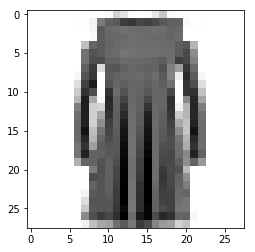

Label:  [2]
Prediction:  [2]


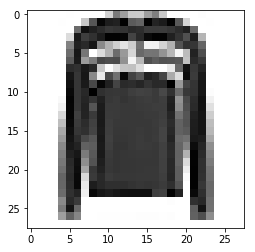

Label:  [2]
Prediction:  [2]


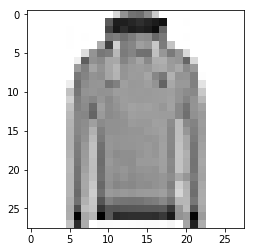

Label:  [3]
Prediction:  [3]


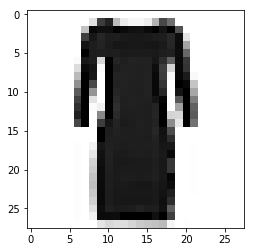

Label:  [0]
Prediction:  [0]


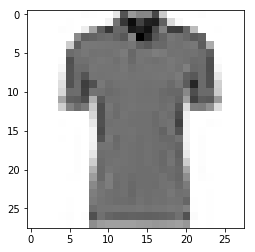

Label:  [8]
Prediction:  [8]


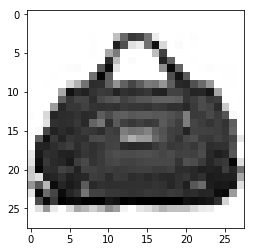

Label:  [6]
Prediction:  [2]


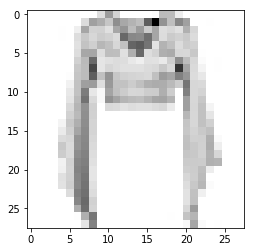

Label:  [1]
Prediction:  [1]


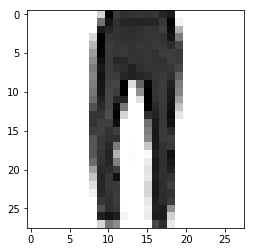

Label:  [0]
Prediction:  [0]


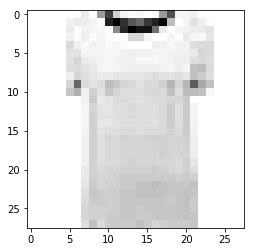

Label:  [2]
Prediction:  [2]


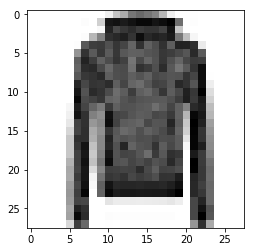

In [6]:
# Get one and predict
Samples = np.random.randint(0, len(Test_x) - 1,size=10)

for r in Samples:
    Label = sess.run(tf.argmax(Y, 1),feed_dict={Y: Test_y_one_hot[r : r + 1]})
    print("Label: ", Label)
    Pred = sess.run(tf.argmax(hypothesis, 1), feed_dict={X: Test_x[r : r + 1]})
    print("Prediction: ", Pred)

    plt.imshow(
        Test_x[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()